# **ETPoF** Homework 4
Annemarie Linnenbank & Tommie Verouden

*5 April 2024*

In [1]:
%load_ext autoreload
%autoreload 2

import pof_piv as piv
import matplotlib.pyplot as plt
import numpy as np

## Particle Image Velocimetry (14 points)
### b1) **Cross-correlation** (2 pts)

Let us first take a look at the images.

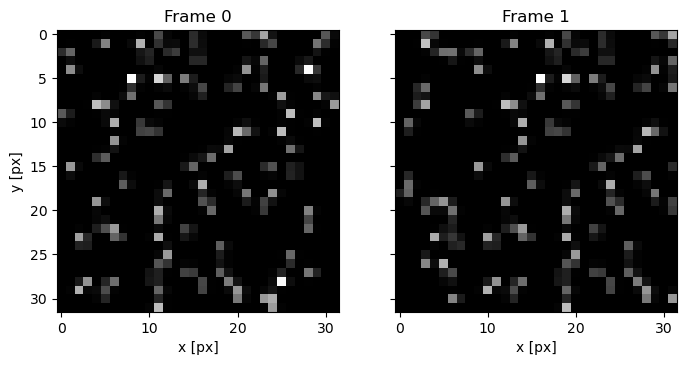

In [2]:
# Load the images
images = piv.read_image_directory('PIVimages/crosscorrelation')

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(images[0], cmap='gray')
ax[1].imshow(images[1], cmap='gray')

ax[0].set_title('Frame 0')
ax[1].set_title('Frame 1')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
plt.show()

The cross-correlation can be calculated using two different functions: directly, or by means of a Fast Fourier Transform. In contrast to what was said in the assignment, according to the documentation of the `scipy.signal.convolve` function, both that function and the `scipy.signal.correlate` automatically determine when each method is fasted (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html#scipy.signal.convolve).

Let us compare both functions.

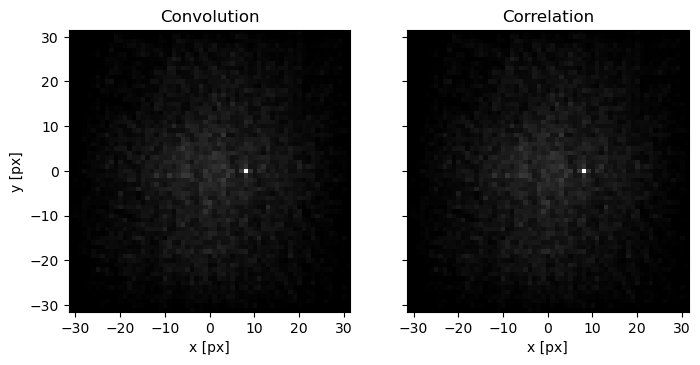

The maximum difference between the convolution and correlation is 4.37e-11, or 8.37e-17 times the maximum value of the correlation.


In [3]:
correlation = piv.correlate_image_pair(images[0], images[1], method='correlate')
convolution = piv.correlate_image_pair(images[0], images[1], method='convolve')

# Define the coordinate system
extent_array = [-images[0].shape[1] + 0.5, images[0].shape[1] - 0.5, -images[0].shape[0] + 0.5,
                 images[0].shape[0] - 0.5] 

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(convolution, cmap='gray', interpolation='none',
             extent=extent_array) 
ax[1].imshow(correlation, cmap='gray', interpolation='none',
             extent=extent_array)

for a in ax:
    # Ticks every ten pixels
    a.set_xticks(np.arange(-30, 31, 10))
    a.set_yticks(np.arange(-30, 31, 10))

ax[0].set_title('Convolution')
ax[1].set_title('Correlation')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
plt.show()

print(f'The maximum difference between the convolution and correlation is {np.max(np.abs(correlation - convolution)):.2e}, or {np.max(np.abs(correlation - convolution)) / np.max(correlation):.2e} times the maximum value of the correlation.')

The results look identical, but on closer inspection the convolution function outputs floats, while the correlation output integers. Trusting that the correlation function will indeed automatically switch to an FFT-based method when it is faster, we will use it for the rest of the assignment.

Next, we will try to find the displacement by first considering the pixel coordinates of the highest peak (indicated by the red star in the plotbelow), and then performing a subpixel refinement by calculating a correction factor based on fitting a Gaussian through the nearest neighbours (see slides lecture 6):
$$\Delta x = \frac{1}{2}\frac{\ln{(I_{n-1}) - \ln{(I_{n+1})}}}{\ln{(I_{n-1})} + \ln{(I_{n+1})} - 2\ln{(I_n)}}.$$

Using a Gaussian makes sense physically, since the light scattered off a small particle will resemble a Gaussian beam. If we do this in the $y$ direction too, we can make the peak position more accurate, as indicated by green star in the plot below.

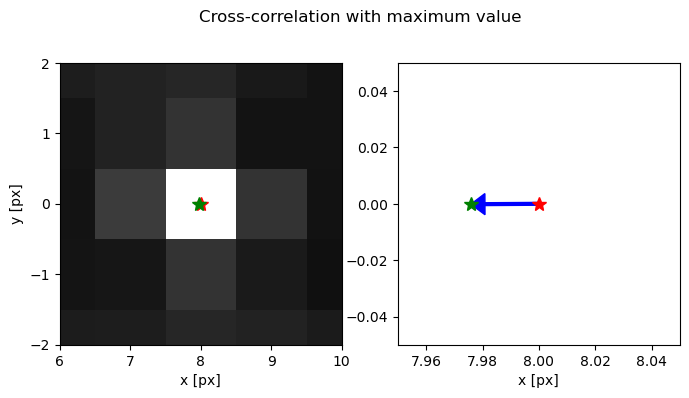

In [4]:
displacement = piv.find_displacement(correlation, subpixel_method=None)
displacement_subpixel = piv.find_displacement(correlation, subpixel_method='gauss_neighbor')

# Plot the cross-correlation with the maximum value
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for a in ax:
    a.imshow(correlation, cmap='gray', interpolation='none', extent=extent_array)
    a.plot(*displacement[::-1], 'r*', markersize=10)
    a.plot(*displacement_subpixel[::-1], 'g*', markersize=10)
    
    a.set_xlabel('x [px]')

# Zoom in around the maximum value
ax[0].set_xlim(displacement[1] - 2, displacement[1] + 2)
ax[0].set_ylim(displacement[0] - 2, displacement[0] + 2)
ax[0].set_xticks(np.arange(-2, 3, 1) + displacement[1]) 
ax[0].set_yticks(np.arange(-2, 3, 1) + displacement[0])

ax[1].set_xlim(displacement[1] - 0.05, displacement[1] + 0.05)
ax[1].set_ylim(displacement[0] - 0.05, displacement[0] + 0.05)

# Blue arrow
ax[1].arrow(*displacement[::-1], *(displacement_subpixel[::-1] - displacement[::-1]), length_includes_head = True, color='b', head_width=0.0075, head_length=0.005)

fig.suptitle('Cross-correlation with maximum value')
ax[0].set_ylabel('y [px]')

plt.show()

### b2) **PIV solver** (9 pts)

Using the functions from the previous part, we have written a simple PIV solver. The solver is based on the following steps:
1. Divide the images into (identical) interrogation windows of given size.
2. Calculate the cross-correlation between the interrogation windows of two images.
3. Find the displacement by finding the maximum of the cross-correlation.
4. Perform subpixel refinement by fitting a Gaussian through the nearest neighbours.
5. Repeat steps 2-4 for all interrogation windows.
6. Optionally, if calibration data is given, calculate the velocity field by dividing the displacement by the time between the two images and multiplying it by the calibration factor in units of length per pixel.

Below, we demonstrate it using the four examples.

#### Shear flow
Here, we use rectangular windows of size $(32, 64)$ to calculate the displacement field. The arrows (scaled up for visibility) in the plot below indicate the displacement, and the windows are outlined in grey.

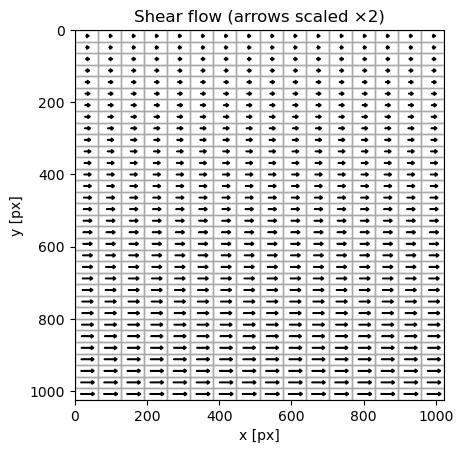

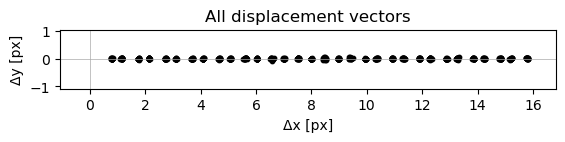

In [5]:
images = piv.read_image_directory('PIVimages/shearflow/')
plot_params = {'arrow_scale':            2,
               'plot_windows':           True,
               'title':                  'Shear flow'}

displacements, coordinates = piv.simple_piv(images, (32, 64), plot=True, plt_flow_params=plot_params, plt_disp_params=plot_params)

We chose rectangular windows because it became clear from the plot of all displacements that the flow is very uniform in the y direction. A window size as small as 2 pixels in the y direction gives correct results (with only slightly larger spread $\Delta y$), but for visualisation purposes, 32 pixels looked best.

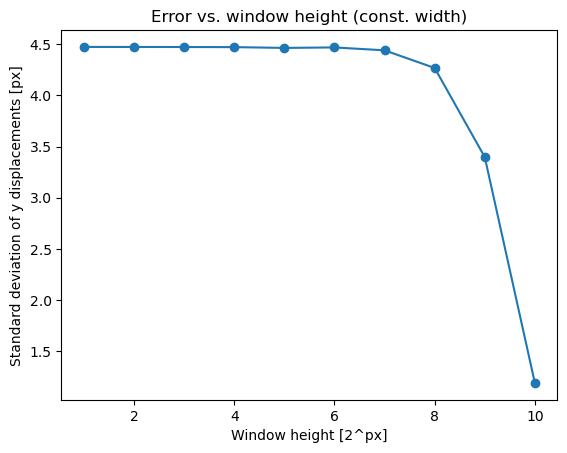

In [6]:
window_size_array = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]

std_y = []
for window_height in window_size_array:
    displ, _ = piv.simple_piv(images, (window_height, 128), plot=False)
    
    # Get the standard deviation of the y displacements
    std_y.append(np.std(displ[:,:,1]))

# Plot the standard deviation of the y displacements vs the window height in a log-log plot
fig, ax = plt.subplots()
ax.plot(np.log2(window_size_array), std_y, 'o-')
ax.set_xlabel('Window height [2^px]')
ax.set_ylabel('Standard deviation of y displacements [px]')
ax.set_title('Error vs. window height (const. width)')
plt.show()

#### Solid body flow
This flow can be correlated best with square windows of size $64 \times 64$. Smaller windows result in trouble calculating the maximum peak in the correlation; multiple maxima are found, indicating that the displacement is most likely not within the window. This could be solved by implementing more sophisticated methods, such as window shifting.

From the displacement vector scatter plot, the rotation of the flow could be accurately determined by looking at the angles of the lines in the plot (like in assignment 2). 

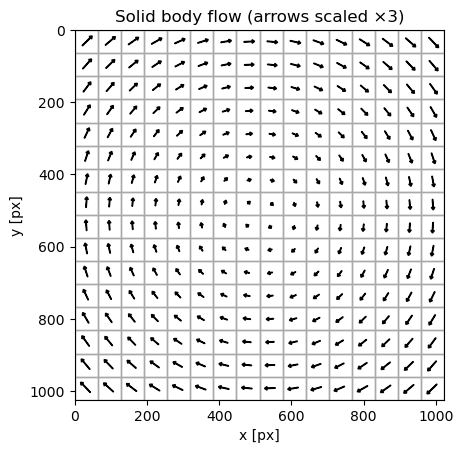

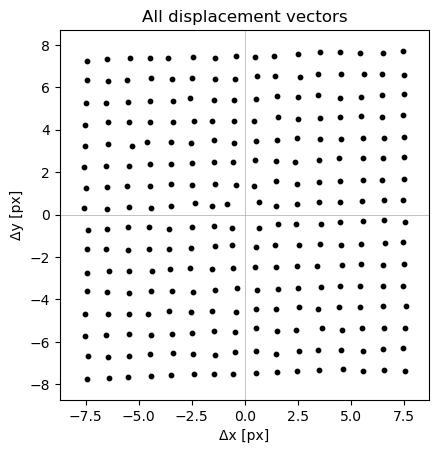

In [7]:
images = piv.read_image_directory('PIVimages/solidbody/')
plot_params = {'arrow_scale':  3,
               'arrow_color':  'k',
               'plot_windows': True,
               'title':        'Solid body flow'}

displacements, coordinates = piv.simple_piv(images, 64, plot=True,
                                            plt_flow_params=plot_params,
                                            plt_disp_params=plot_params)


#### Strange flow
This flow has very small displacements, so a $16 \times 16$ window is the most precise choice that does not result in the "multiple maxima" error. Below, we have highlighted displacements larger than $0.01$ pixels in blue, a function that could be later used to filter outliers. Here, its main purpose is speeding up the visualisation, because the arrows with negligible displacements can be plotted all at once as dots.

From the displacements plot, it also becomes clear that most arrows are bunched together around a $45^\circ$ angle, leading us to suspect that the lonely points are errors.

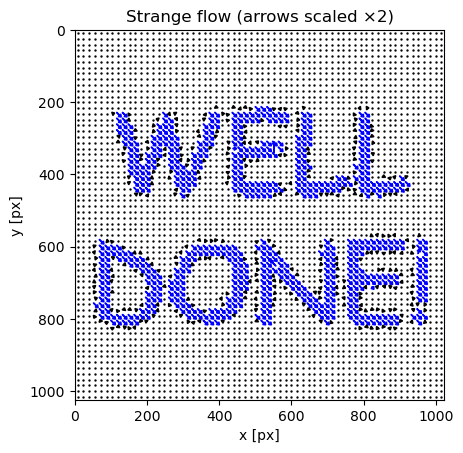

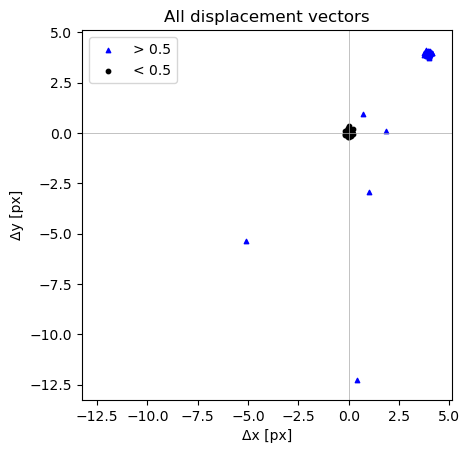

In [8]:
images = piv.read_image_directory('PIVimages/strangeflow/')
plot_params = {'arrow_scale':  2,
               'zero_displ_thr': 0.01,  
               'plot_windows': False,
               'highlight_radius_range': [0.5, np.inf],
               'title':        'Strange flow',
               'legend':       ['> 0.5', '< 0.5']}

displacements, coordinates = piv.simple_piv(images, 16, plot=True,
                                            plt_flow_params=plot_params,
                                            plt_disp_params=plot_params)

#### Commercial flow
The final example also works best with a $16 \times 16$ interrogation window, and shows a very nice logo.

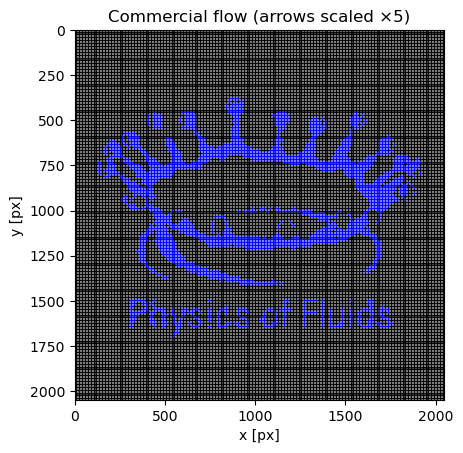

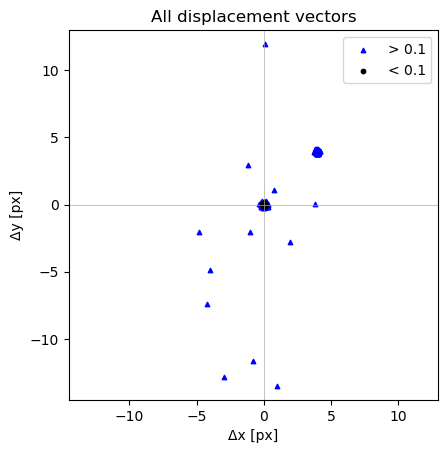

In [9]:
images = piv.read_image_directory('PIVimages/commercialflow/')
plot_params = {'arrow_scale':            5,
               'plot_windows':           False,
               'zero_displ_thr':         100,
               'highlight_radius_range': [0.1, np.inf],
               'title':                  'Commercial flow',
               'legend':                 ['> 0.1', '< 0.1']}

displacements, coordinates = piv.simple_piv(images, 16, plot=True, plt_flow_params=plot_params,plt_disp_params=plot_params)

### b3) **Tracer density & shift** (1.5 pts)
We now analyse a set of images with varying tracer density.

/Users/tommieverouden/PycharmProjects/ETPoF/pof_piv/pof_piv/helper_functions.py:134: RuntimeWarning: divide by zero encountered in log
  correction = [(0.5 * (np.log(neighbor[0]) - np.log(neighbor[2]))
/Users/tommieverouden/PycharmProjects/ETPoF/pof_piv/pof_piv/helper_functions.py:135: RuntimeWarning: divide by zero encountered in log
  / ((np.log(neighbor[0])) + np.log(neighbor[2]) -
/Users/tommieverouden/PycharmProjects/ETPoF/pof_piv/pof_piv/helper_functions.py:134: RuntimeWarning: invalid value encountered in scalar divide
  correction = [(0.5 * (np.log(neighbor[0]) - np.log(neighbor[2]))


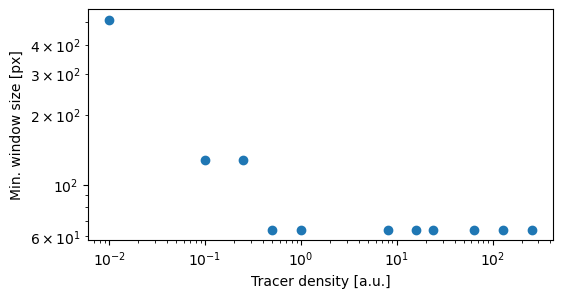

In [10]:
images_sets, set_names = piv.read_image_sets('PIVimages/tracerDensity/', grouping_ab=True)

# Test the simple PIV function to see at which window size it gives an error about multiple maxima.
min_window_size = []
for i in range(len(images_sets)):
    for window_size in window_size_array:
        try:
            u, v = piv.simple_piv(images_sets[i], window_size, plot=False)
        except:
            min_window_size.append(window_size * 2)
            break
            
# Convert the names to floats
particle_size = [float(i) for i in set_names]

# Make a log-log plot of the particle size vs the minimum window size
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(particle_size, min_window_size, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Tracer density [a.u.]')
ax.set_ylabel('Min. window size [px]')
plt.show()

The plot shows that the minimum window size required to avoid the "multiple maxima" error decreases with the tracer density. This is expected, as the higher the tracer density, the more likely it is that multiple particles are present in the window, leading to multiple maxima in the correlation.

_Note: the subpixel refinement method also sometimes gives an error, in most cases due to a pixel of value 0, or due to a maximum being at the edge of a window. The latter problem could be solved by implementing a window shifting method or taking overlapping windows._

A similar analysis can be performed for varying particle shifts.

/Users/tommieverouden/PycharmProjects/ETPoF/pof_piv/pof_piv/helper_functions.py:134: RuntimeWarning: invalid value encountered in scalar subtract
  correction = [(0.5 * (np.log(neighbor[0]) - np.log(neighbor[2]))


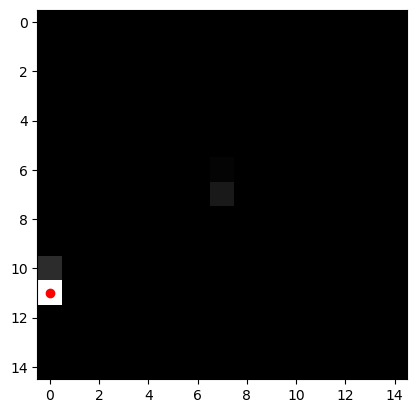

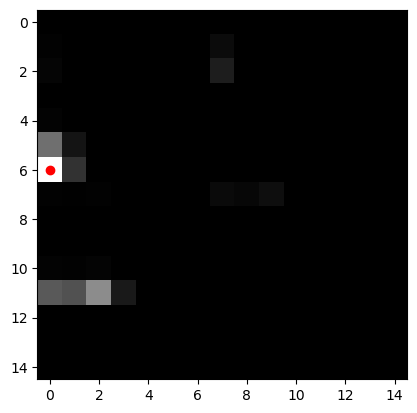

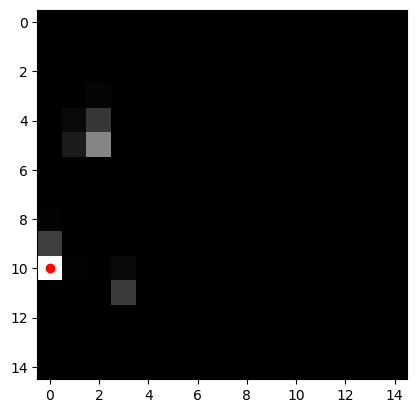

Peak is at the edge of the correlation array
Peak is at the edge of the correlation array
Peak is at the edge of the correlation array
Peak is at the edge of the correlation array


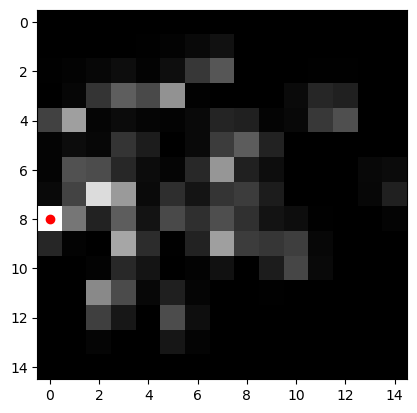

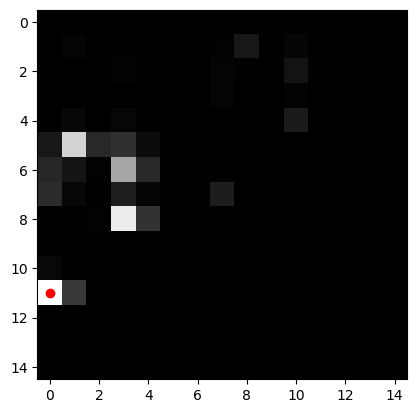

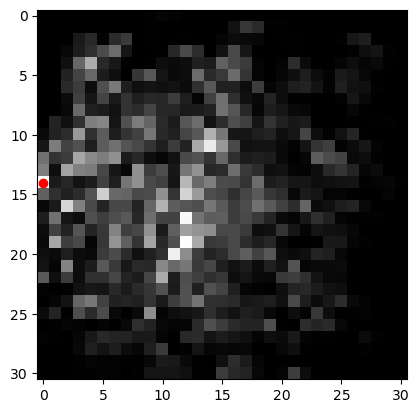

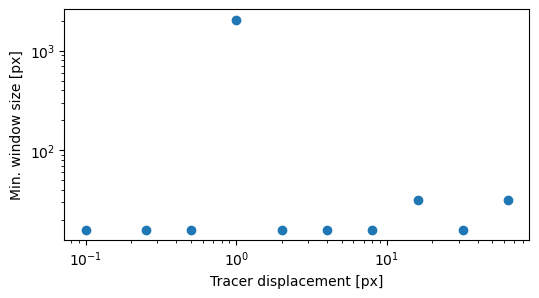

In [11]:
images_sets, set_names = piv.read_image_sets('PIVimages/tracerDisplacement/', grouping_ab=True)

# Test the simple PIV function to see at which window size it gives an error about multiple maxima.
min_window_size = []
for i in range(len(images_sets)):
    for window_size in window_size_array:
        try:
            u, v = piv.simple_piv(images_sets[i], window_size, plot=False)
        except:
            min_window_size.append(window_size * 2)
            break
            
# Convert the names to floats
particle_size = [float(i) for i in set_names]

# Make a log-log plot of the particle size vs the minimum window size
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(particle_size, min_window_size, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Tracer displacement [px]')
ax.set_ylabel('Min. window size [px]')
plt.show()

### b4) **Suboptimal images** (1.5 pts)

#### Leaky particles

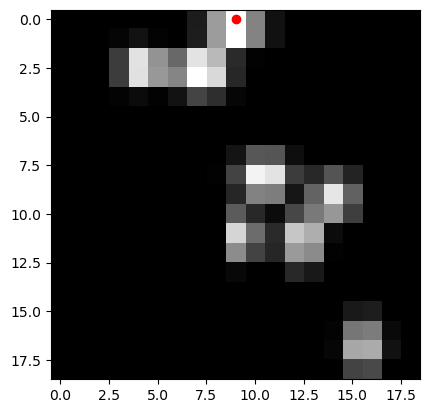

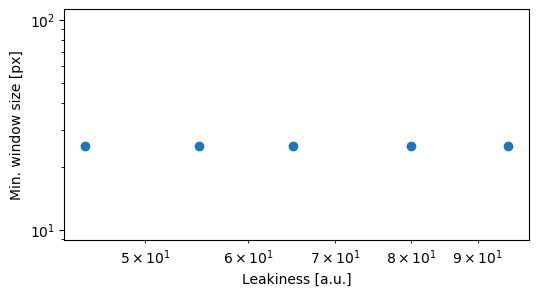

In [12]:
images_sets, set_names = piv.read_image_sets('PIVimages/Suboptimal/', 'LeakyParticles', grouping_ab=True)

# Test the simple PIV function to see at which window size it gives an error about multiple maxima.
window_size_array = [1000, 500, 250, 125, 100, 25, 10, 5]
min_window_size = []
for k in range(len(images_sets)):
    for l in range(len(window_size_array)):
        try:
            u, v = piv.simple_piv(images_sets[k], window_size_array[l], plot=False)
        except:
            min_window_size.append(window_size_array[l-1])
            break
            
# Convert the names to floats
leakiness = [float(i) for i in set_names]

# Make a log-log plot of the particle size vs the minimum window size
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(leakiness, min_window_size, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Leakiness [a.u.]')
ax.set_ylabel('Min. window size [px]')
plt.show()

#### Uneven lighting

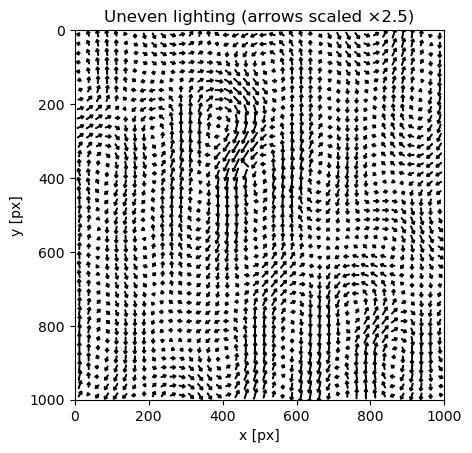

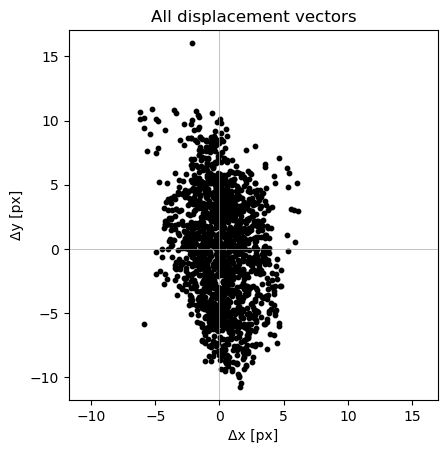

In [13]:
images_sets, set_names = piv.read_image_sets('PIVimages/Suboptimal/', 'UnevenLighting', grouping_ab=True)

plot_params = {'arrow_scale':            2.5,
               'plot_windows':           False,
               'title':                  'Uneven lighting'}

displacements, coordinates = piv.simple_piv(images_sets[0], 25, plot=True, plt_flow_params=plot_params, plt_disp_params=plot_params)